In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import requests
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
fig_dim = (13,10)

In [2]:
# Carol
path = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3'

## Cleaning Data

In [ ]:
# Opening and saving given dataset
#df = pd.read_csv(path+'/'+"bike_loans.csv", sep=";")
#pickle.dump(df, open(path+'/'+"df_raw", "wb"))

In [ ]:
# Opening data
df = pickle.load(open(path+'/'+"df_raw", "rb" ))

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.shape

## Exploratory Data Analysis

In [ ]:
def eda_to_df(df):
    header="+" + ("-"*85) + "+"
    form = "+{:^25s}|{:^10s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), #Column
                          str(df[col].dtypes), #Type
                          str(len(df[col].unique())), #Uniques
                          str(df[col].isnull().values.any()), #NaN?
                          str(df[col].isnull().sum()),
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)) )) #%NaN
    print(header)

eda_to_df(df)

[ANÁLISE TABELA]

Importe e DescripcionImporte têm apenas um valor que se repete em todas as linhas e por isso são removidos

In [ ]:
df = df.drop(['Importe', 'DescripcionImporte'], axis=1)

***Looking for relations between NaN values in columns Id_Aparcamiento_Destino, Posicion_Destino and operario***

In [ ]:
df_apar_destino = df[df['Id_Aparcamiento_Destino'].isnull()]
print('Number of NaN in Id_Aparcamiento_Destino column: ', len(df_apar_destino))

df_pos_destino = df[df['Posicion_Destino'].isnull()]
print('\nNumber of NaN in Posicion_Destino column: ', len(df_pos_destino))

df_pos_apar = df[(df['Id_Aparcamiento_Destino'].isnull()) & (df['Posicion_Destino'].isnull())]
print('\nNumber of rows when Id_Aparcamiento_Destino and Posicion_Destino are NaN: ', len(df_pos_apar))

df_pos_apar_ope = df[(df['Id_Aparcamiento_Destino'].isnull()) & (df['Posicion_Destino'].isnull()) & (df['operario']=='monitor')]
print('\nNumber of rows when Id_Aparcamiento_Destino and Posicion_Origen are NaN and the operario is monitor: ', len(df_pos_apar_ope))

df_pos_apar_ope_null = df[(df['Id_Aparcamiento_Destino'].isnull()) & (df['Posicion_Destino'].isnull()) & (df['operario'].isnull())]
print('\nNumber of rows when Id_Aparcamiento_Destino, Posicion_Origen and operario are NaN: ', len(df_pos_apar_ope_null))

In [ ]:
df_apar_destino.head()

Quando o Id_Aparcamiento_Destino tem valores NaN não conseguimos saber qual a estação de destino. Por essa razão esses dados não nos interessam pois não trazem informação ao modelo que irá ser construído. 

In [ ]:
df = df[df['Id_Aparcamiento_Destino'].notna()]

***Calculating the usage duration of bicycles***

In [ ]:
def duration (prestamo, devolucion):

    start = datetime.datetime.strptime(prestamo[0:19], "%Y-%m-%d %H:%M:%S")
    end = datetime.datetime.strptime(devolucion[0:19], "%Y-%m-%d %H:%M:%S")
    time = end - start
    seconds = time.total_seconds()

    return seconds

In [ ]:
df['Duration'] = df.apply(lambda x: duration(x['Fecha_Prestamo'],x['Fecha_Devolucion']),axis=1)

***Removing data when the usage duration of bicycles is negative (which means that the day of prestamo is after the day of devolucion)***

In [ ]:
df = df[df['Duration']>0]

***Removing data before 2016 and after 2020***

In [ ]:
def year_ (row):
    
    year = int(row[0:4])

    return year

In [ ]:
df_list = []
increment = 1000000
for i in range(0,15000000, increment):
    df_ = df.iloc[i:i+increment,:]
    #creating column with the year of prestamo and devolucion
    df_['Year_Prestamo'] = df_.apply(lambda x: year_(x['Fecha_Prestamo']),axis=1) 
    df_['Year_Devolucion'] = df_.apply(lambda x: year_(x['Fecha_Devolucion']),axis=1) 
    #removing years before 2016 and after 2020
    df_= df_[(df_['Year_Prestamo']>=2016) & (df_['Year_Prestamo']<2020)]
    df_= df_[(df_['Year_Devolucion']>=2016) & (df_['Year_Devolucion']<2020)]
    df_list.append(df_)

#creating cleaned dataframe
df_new_ = pd.DataFrame()
df_clean_ = df_new_.append(other=df_list,ignore_index=True)

#confirming
print(df_clean_['Year_Prestamo'].unique())
print(df_clean_['Year_Devolucion'].unique())

In [ ]:
df_clean_

***Encoding categorical features***

In [ ]:
print('Number of NaN in column Id_Tag_Bicicleta: ', df_clean_['Id_Tag_Bicicleta'].isnull().sum())
print('\nNumber of NaN in column operario: ', df_clean_['operario'].isnull().sum())

In [ ]:
operario_ = df_clean_['operario'].fillna(value='other')
df_clean_['operario'] = operario_

In [ ]:
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

In [ ]:
enc, df_clean_ = encode_categorical_features(df_clean_, ["Id_Tag_Bicicleta", "operario"])
df_clean_.head()

In [ ]:
#Saving cleaned dataframe
pickle.dump(df_clean_, open(path+'/'+"df_clean", "wb" ))

## External Data

***Acessing dataframe***

In [3]:
# Opening cleaned data
df = pickle.load(open(path+'/'+"df_clean", "rb" ))

# Opening raw data
#df = pickle.load(open(path+'/'+"df_raw", "rb" ))

df.Fecha_Prestamo=pd.to_datetime(df.Fecha_Prestamo)
df.Fecha_Devolucion=pd.to_datetime(df.Fecha_Devolucion)

df['month_prestamo'] = df.Fecha_Prestamo.dt.month
df['day_prestamo'] = df.Fecha_Prestamo.dt.day
df['hour_prestamo'] = df.Fecha_Prestamo.dt.hour

df['month_devolucion'] = df.Fecha_Devolucion.dt.month
df['day_devolucion'] = df.Fecha_Devolucion.dt.day
df['hour_devolucion'] = df.Fecha_Devolucion.dt.hour

df = df.rename(columns={'Year_prestamo':'year_prestamo', 'Year_devolucion':'year_devolucion'})

***Holidays***

In [4]:
holidays16 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2016')
holidays17 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2017')
holidays18 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2018')
holidays19 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2019')

In [5]:
holidays = pd.concat([holidays16, holidays17, holidays18, holidays19])
df['DATE'] = df['Fecha_Prestamo'].dt.date.astype(str)
dfDATE_count = df.groupby('DATE').size().reset_index(name='count')
holidays_count = pd.merge(dfDATE_count,holidays,on='DATE')

<AxesSubplot:xlabel='DATE', ylabel='count'>

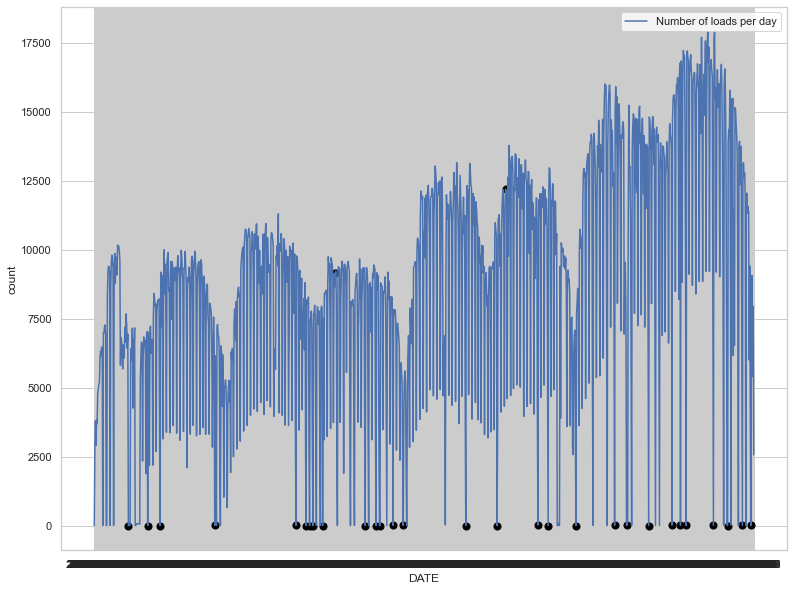

In [6]:
fig, ax = plt.subplots(figsize=fig_dim)

sns.lineplot(data=dfDATE_count, x="DATE", y="count",  ax=ax, label="Number of loads per day")

sns.regplot(data=holidays_count, x="DATE", y="count", fit_reg=False, scatter_kws={"color":"black","alpha":1,"s":50}, ax=ax)

***Wheather***

In [ ]:
def get_history(city_name, start_date, end_date):
    print("Retrieving {0} history...".format(city_name))
    
    api = "155b4d6acbf49ae8044c54f654953578"
    
    url = "http://history.openweathermap.org/data/2.5/aggregated/year?q=" + city_name + ",CO&appid=" + api \
                + "&start="+ start_date + "&end=" + end_date \
    
    
    request_json=requests.get(url).json()
    if "result" not in request_json:
        return get_history(city_name)
    
    return pd.json_normalize(request_json["result"])

In [ ]:
weather_data = get_history("Itagui","2020-01-01","2020-12-31")

***Aggregating weather and bycicle information***

In [ ]:
dfY = df[df['year_prestamo']==2019] ################################### MUDAR DEPOIS DE RECEBER NOVOS DADOS OPENWEATHER

In [ ]:
dfYMD = dfY.groupby(['year_prestamo','month_prestamo','day_prestamo']).size().reset_index(name='count')

In [ ]:
dfYMD = dfYMD.rename(columns={'year_prestamo':'year', 'month_prestamo':'month', 'day_prestamo':'day'})

In [ ]:
weather_analysis = pd.merge(dfYMD,weather_data,on=['month','day'])

In [ ]:
weather_analysis.head()

In [ ]:
def df_weather (data, feat):
    weather_ = [column for column in data if column.startswith(feat)]
    weather_.append('count')
    weather = data[weather_]
    cor = weather.corr()
    
    fig,ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cor, annot=True)

In [ ]:
df_weather(weather_analysis, "temp")

In [ ]:
df_weather(weather_analysis, "pressure")

In [ ]:
df_weather(weather_analysis, "humidity")

In [ ]:
df_weather(weather_analysis, "wind")

In [ ]:
df_weather(weather_analysis, "precipitation")